## Loading the Data


In [2]:
# These are tools we need for our project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read our housing data from a CSV file (like a spreadsheet)
df = pd.read_csv(r"C:\Users\jenaa\Downloads\Housing.csv")

# Let's see what our data looks like
print("Dataset Shape:", df.shape)  # How many rows and columns we have
print("First 5 rows:")
print(df.head())                   # Show the first 5 rows

# More information about our data
print("\nDataset Info:")
df.info()                          # Shows data types and if we're missing data

print("\nSummary Statistics:")
print(df.describe())               # Shows average, min, max, etc. for numbers

Dataset Shape: (545, 13)
First 5 rows:
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIn

## Checking for Missing Values


Missing Values:
Series([], dtype: int64)


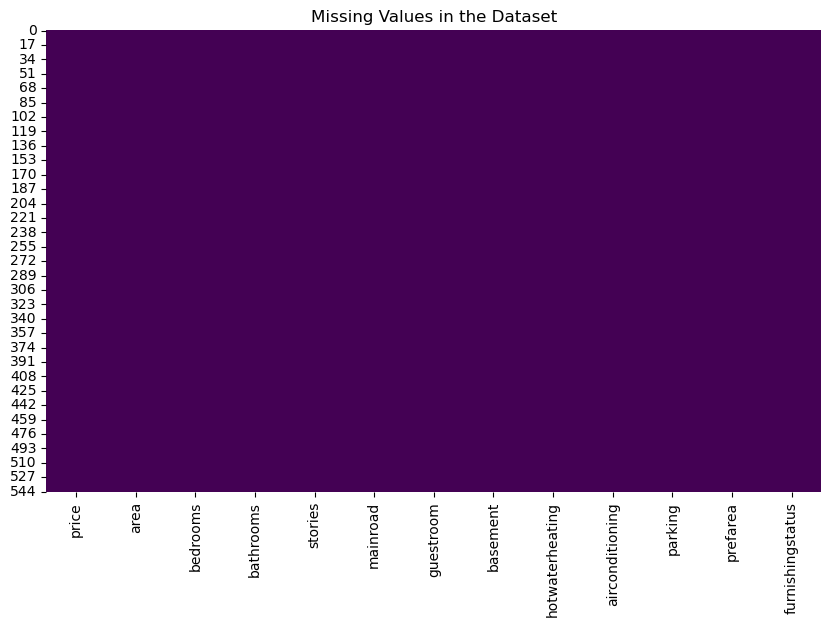

In [3]:
# Count how many missing values we have in each column
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values[missing_values > 0])  # Only show columns with missing values

# Create a visual representation of missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values in the Dataset")
plt.show()

## Filling in Missing Values

In [4]:
# Fill in missing values - for each column:
# If it's text (categorical), use the most common value
# If it's a number, use the middle value (median)
for col in df.columns:
    if df[col].dtype == 'object':  # 'object' means text data
        df[col].fillna(df[col].mode()[0], inplace=True)  # Use most common value
    else:
        df[col].fillna(df[col].median(), inplace=True)   # Use middle value

# Check that we've filled all missing values
print("\nMissing Values after Imputation:")
print(df.isnull().sum())

# See what our data looks like now
print("\nProcessed DataFrame Head:")
print(df.head())


Missing Values after Imputation:
price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

Processed DataFrame Head:
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no      

## Converting Categories to Numbers

In [5]:
# Computers can't understand text, so we convert categories to numbers
# This is called "one-hot encoding"
categorical_cols = df.select_dtypes(include=['object']).columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

## Scaling the Data

In [6]:
# Import a tool to scale our numbers
from sklearn.preprocessing import StandardScaler

# We'll scale all columns except the price (our target)
target = 'price'
feature_cols = [col for col in df_encoded.columns if col != target]

# Create a scaler and apply it to our features
scaler = StandardScaler()
df_encoded[feature_cols] = scaler.fit_transform(df_encoded[feature_cols])

## Visualizing Relationships

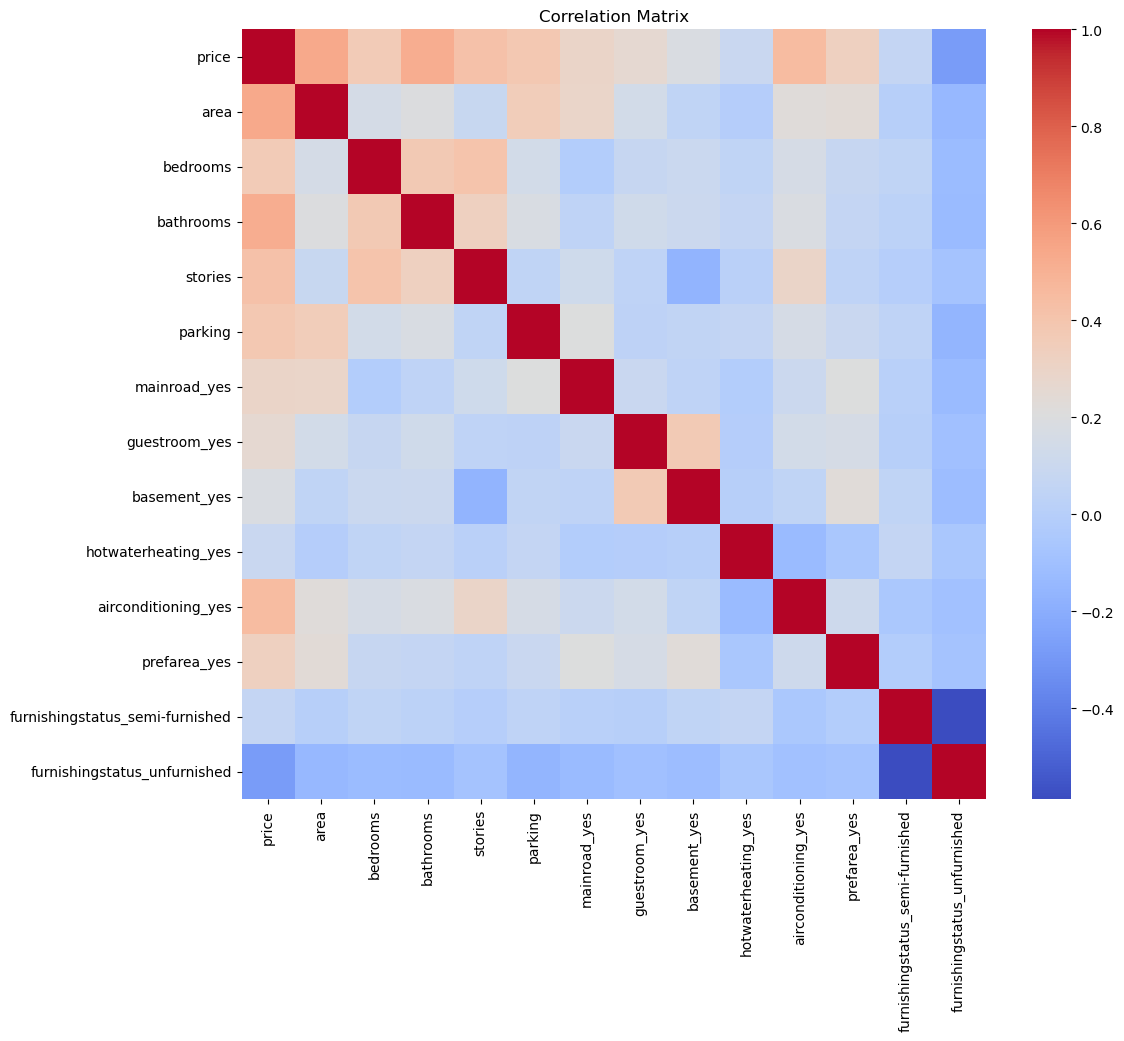

In [7]:
# Create a heat map to see how features relate to each other
plt.figure(figsize=(12, 10))
correlation_matrix = df_encoded.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation Matrix")
plt.show()

## Preparing for Training

In [8]:
# Import tools for model training and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import pickle

# Separate features (X) from what we're trying to predict (y)
X = df_encoded.drop(target, axis=1)  # All columns except price
y = df_encoded[target]               # Just the price column

# Split our data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training a Basic Model

In [9]:
# Create a RandomForest model (a collection of decision trees)
rf = RandomForestRegressor(random_state=42)

# Train the model using our training data
rf.fit(X_train, y_train)

# Use the model to make predictions on our test data
y_pred = rf.predict(X_test)

# Evaluate how well the model did
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)           # Mean Absolute Error
r2 = r2_score(y_test, y_pred)                       # R² score (1.0 is perfect)

print("Baseline Model Performance:")
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

Baseline Model Performance:
RMSE: 1399787.9202564885
MAE: 1017470.6224770641
R²: 0.6123495913214113


## Improving the Model

In [10]:
# Define different settings to try for our model
param_grid = {
    'n_estimators': [100, 200],           # Number of trees
    'max_depth': [None, 10, 20],          # How deep each tree can grow
    'min_samples_split': [2, 5],          # Min samples needed to split a node
}

# Automatic search for the best combination of settings
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', 
                           n_jobs=-1, verbose=2)

# Train models with different combinations
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_
print("\nBest Parameters Found:", grid_search.best_params_)

# Test the improved model
y_pred_best = best_model.predict(X_test)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print("\nOptimized Model Performance:")
print("RMSE:", rmse_best)
print("MAE:", mae_best)
print("R²:", r2_best)

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best Parameters Found: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

Optimized Model Performance:
RMSE: 1423508.5183597018
MAE: 1032500.7457873068
R²: 0.5991001404517


## Saving the Model for Later Use

In [11]:
# Save our trained model so we can use it later without retraining
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Also save the tools we used to prepare the data
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)
    
with open('feature_cols.pkl', 'wb') as file:
    pickle.dump(feature_cols, file)
    
print("\nModel, scaler, and feature columns have been saved.")


Model, scaler, and feature columns have been saved.


## Randoms below for reference

In [12]:
import pickle

with open("feature_cols.pkl", "rb") as f:
    feature_cols = pickle.load(f)

print("Required Features:", feature_cols)

Required Features: ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'mainroad_yes', 'guestroom_yes', 'basement_yes', 'hotwaterheating_yes', 'airconditioning_yes', 'prefarea_yes', 'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished']


### curl -X POST http://127.0.0.1:5000/predict -H "Content-Type: application/json" -d "{\"area\":5000,\"bedrooms\":3,\"bathrooms\":2,\"stories\":2,\"parking\":1,\"mainroad_yes\":1,\"guestroom_yes\":0,\"basement_yes\":1,\"hotwaterheating_yes\":0,\"airconditioning_yes\":1,\"prefarea_yes\":1,\"furnishingstatus_semi-furnished\":0,\"furnishingstatus_unfurnished\":0}"

In [1]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip list > requirements1.txt

Note: you may need to restart the kernel to use updated packages.
